# create smooth distributions

Our goal is to create smooth shapes from this dataset and connect them with income mountain as the long tail for income mountain.

First of all we will look at what's available in this dataset

The groups available are

- < 10,000
- between 10,000 and 100,000
- between 100,000 and 1,000,000
- \> 1,000,000 

these are wealth groups and we should convert them to daily income using this formula

`income = wealth * 0.03 / 365`

(Assuming the annual growth rate of capital is 3%)

In [4]:
levels = [10000, 100000, 1000000]

def wealth_to_daily_income(x):
    return x * 0.03 / 365

_ = [print(x, ': ', wealth_to_daily_income(x), '$/day') for x in levels]

10000 :  0.821917808219178 $/day
100000 :  8.219178082191782 $/day
1000000 :  82.1917808219178 $/day


Also convert daily income to the group number we are using in income mountains

In [5]:
all_brackets = np.logspace(-7, 13, 51, endpoint=True, base=2)
brackets_delta = (13 - (-7)) / 50


def bracket_number_from_income(s, mountly=False, integer=True):
    if mountly:  # calculate daily income
        res = ((np.log2(s / 30) + 7) / brackets_delta)
    else:
        res = ((np.log2(s) + 7) / brackets_delta)
    if integer:
        return res.astype(int)
    return res

In [6]:
levels_groups = [bracket_number_from_income(wealth_to_daily_income(x), integer=True) for x in levels]
_ = [print(x, ': in group', y) for x, y in zip(levels, levels_groups)]

10000 : in group 16
100000 : in group 25
1000000 : in group 33


So the available groups in terms of income mountain group numbers are

- < 16
- 16 - 25
- 25 - 33
- \> 33

There is no upper bound / lower bound for these groups. Let's add the boundaries

For lower bound, just use group 0

for upper bound, we use the group number calculated with daily income for Bezos and add by 2 


In [7]:
max_income = 5310000000 / 365  # daily income for bezos, from Forbes dataset
max_income_group = bracket_number_from_income(max_income) + 2

In [16]:
print(max_income_group)

78


So avaliable groups in the source data are:

- 0 - 16
- 16 - 25
- 25 - 33
- 33 - 78

And group 0 - 49 is available in income mountain dataset

So we are interested in group 50 - 78. All of them are in the last group of available data

Now plot some data to see it visually 

(for example USA 2020)

In [8]:
data = pd.read_csv('../../ddf--datapoints--adult_percentage--by--geo--time--income_level.csv')
total_adults = pd.read_csv('../../ddf--datapoints--adults_thousands--by--geo--time.csv').set_index(['geo', 'time'])

In [9]:
m = {
    'level1': levels_groups[0],
    'level2': levels_groups[1],
    'level3': levels_groups[2],
    'level4': max_income_group
    }
    

In [10]:
def uniform_pmf(x, n, n_begin=0):
    xs = np.linspace(n_begin, n_begin+n, n, endpoint=False)
    ys = np.ones(n) * (x / n)
    return pd.Series(ys, index=xs)

In [20]:
def get_data(geo, time):
    df = data[data['geo'] == geo].copy()
    df['income_level'] = df['income_level'].map(lambda x: m[x])
    df.columns = ['geo', 'time', 'income_level', 'adult_percentage']
    dfg = df.set_index(['time', 'income_level'])['adult_percentage']
    dfg2 = dfg.loc[time].copy()
    return dfg2

def get_uniform_dist(geo, time):
    df = get_data(geo, time)
    last_g = 0
    res = []

    for i, v in df.iteritems():
        res.append(uniform_pmf(v, i - last_g, last_g))
        last_g = i 

    res = pd.concat(res)
    res.loc[78] = 0  # set last group to 0
    return res

def plot_dist(res):
    for i, p in res.iteritems():
        plt.bar(i, p, color='blue', alpha=0.5)
    

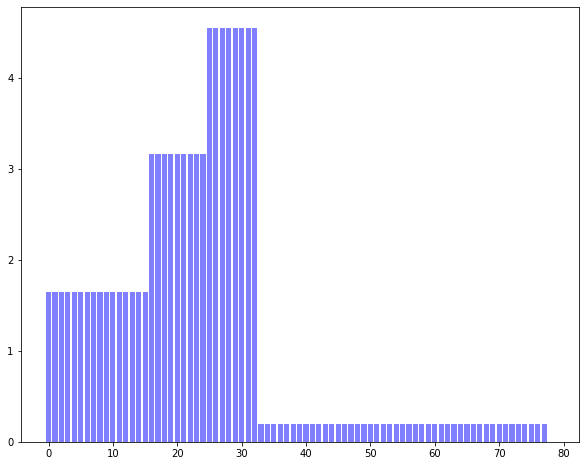

In [21]:
res = get_uniform_dist('usa', 2020)
plot_dist(res)

In above chart, the population distributed uniformly in each group. 

I think that if we use the method that we used to smooth the income mountain to calculate the smooth version, the tail might be still very flat as there are too many groups with the same value

also it's hard to make the entire shape looks smooth 

In [14]:
import sys
sys.path.insert(0, '../scripts')
import smoothlib

sum: 1.0


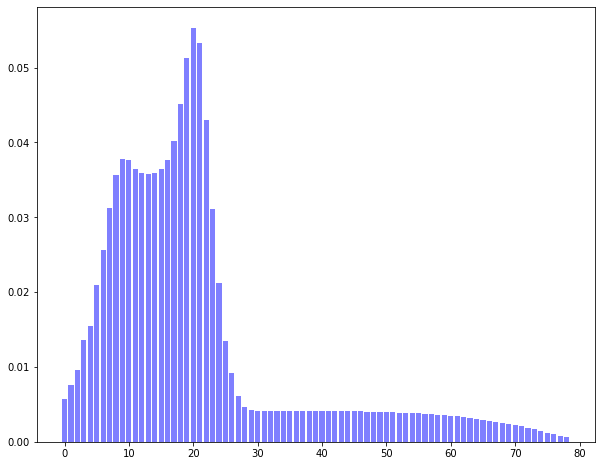

In [41]:
r1 = smoothlib.run_smooth(res, 20, 8)
r1 = smoothlib.run_smooth(r1, 10, 2)
r1 = smoothlib.run_smooth(r1, 8, 2)
r1 = smoothlib.run_smooth(r1, 5, 2)
r1 = smoothlib.run_smooth(r1, 5, 1)
r1 = smoothlib.run_smooth(r1, 5, 1)
r1 = smoothlib.run_smooth(r1, 5, 1)
r1 = smoothlib.run_smooth(r1, 5, 0)
# make sure the curve sum to 100
r1 = r1 / r1.sum()

plot_dist(r1)
print("sum:", r1.sum())

In [17]:
adults = total_adults.loc['usa', 2020]['adults_thousands']

In [42]:
adults * r1[60:] * 1000

60    867574.180716
61    846719.098605
62    823941.372919
63    799143.527922
64    772137.585157
65    742791.160415
66    711032.289433
67    676853.114698
68    640311.445339
69    600436.181457
70    557751.155184
71    512818.488208
72    466229.224049
73    418593.632447
74    359102.981040
75    303223.399423
76    251218.514286
77    203304.434017
78    159646.660657
dtype: float64

Above are number of people in each group for group > 60. There are too many people in Group > 60 in this case.

Alternativly we could try to assign an other distribution to the tail, so that it's not uniformly distributed. 

But in this case the shape will be mainly defined by the initial distribution

For example use a zeta distribution for the tail:

In [70]:
# define the distribution PMF to use

# import scipy.special
# def betabinomial_pmf(x, size, a, b):
#     return scipy.special.comb(size, x) * scipy.special.beta(x + a, size - x + b) / scipy.special.beta(a, b)
# # calling function
# pmf = betabinomial_pmf(np.linspace(0, 16, 17) , 16, 5, 1)

# for i, p in enumerate(pmf):
#     plt.bar(i, p, color='blue', alpha=.5)

In [45]:
from scipy.stats import zipf

the tail distribution:


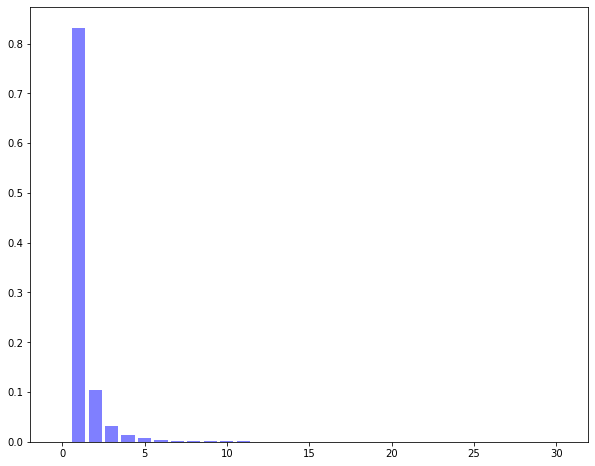

In [115]:
print("the tail distribution:")
xs = np.linspace(0, 30, 31)
for i in xs:
    plt.bar(i, zipf.pmf(i, 3), color='blue', alpha=.5)

In [48]:
zipf.pmf(xs, 3).sum()

0.9995529782629969

In [75]:
dfg2 = get_data('usa', 2020)
dfg2

income_level
16    26.3
25    28.5
33    36.4
78     8.8
Name: adult_percentage, dtype: float64

In [86]:
# dist before 16
num = 16
xs = np.linspace(0, num-1, num)
# ps = xs / xs.sum()
# df16 = pd.Series(ps, index=xs) * dfg2.loc[16]
df16 = uniform_pmf(dfg2.loc[16], num)
# df16 = pd.Series(ps, index=xs)
# df16 = df16.sort_index()

In [88]:
df16.sum()

26.3

In [89]:
# dist after 33
num = 78 - 34
xs = np.linspace(0, num, num+1)
# ps = xs / xs.sum()
# df76 = pd.Series(ps, index=xs[::-1]+34) * dfg2.loc[76]
# ps = betabinomial_pmf(xs, num, 5, 1) * dfg2.loc[76]
ps = zipf.pmf(xs+1, 4)
df76 = pd.Series(ps, index=xs+34) * dfg2.loc[78]
df76 = df76.sort_index()

In [90]:
df76.sum()

8.799971234933102

In [102]:
# 16-25
num = 25 - 15
fst = df16.iloc[-1]
mean = dfg2.iloc[1] / num
total = dfg2.iloc[1]
sumnum = sum([n for n in range(num)])

step = (total - num * fst) / sumnum

# print(total, mean)

In [103]:
# xs = [(fst + n * step) for n in range(num)]
xs = np.ones(num) * mean
d2 = pd.Series(xs, index=range(16, 26))

In [93]:
# 25-33
num = 33 - 25
last = df76.iloc[0]
total = dfg2.iloc[2]
mean = total / num
sumnum = sum([n for n in range(num)])

step = (total - num * last) / sumnum

# print(total, mean)

In [94]:
# xs = [(last + n * step) for n in range(num)]
# d3 = pd.Series(xs[::-1], index=range(26, 34))
xs = np.ones(num) * mean
d3 = pd.Series(xs, index=range(26, 34))

In [109]:
dist = pd.concat([df16, d2, d3, df76], verify_integrity=True)
# append group 77
# dist.loc[77] = 0

In [110]:
dist = dist.sort_index()
dist = dist / 100
print(dist.sum())  # should be 100%

0.999999712349331


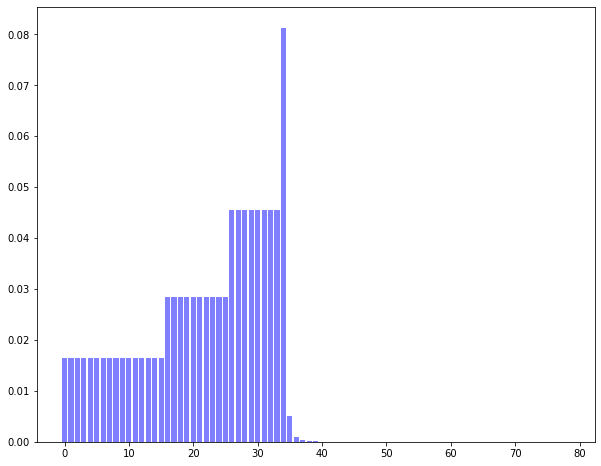

In [108]:
plot_dist(dist)

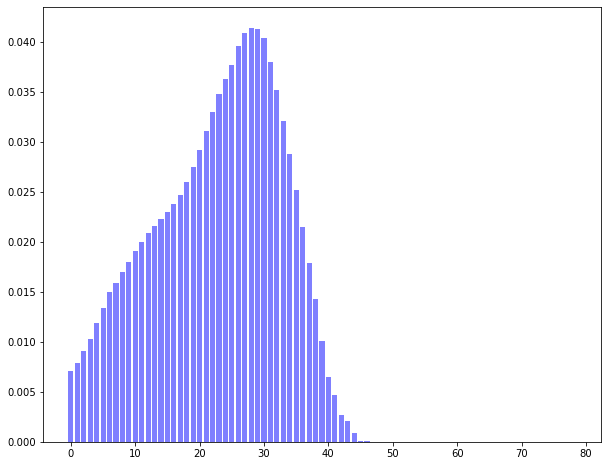

In [111]:
r1 = smoothlib.run_smooth(dist, 20, 6)
r1 = smoothlib.run_smooth(r1, 10, 2)
# r1 = smoothlib.run_smooth(r1, 8, 1)
# r1 = smoothlib.run_smooth(r1, 5, 1)
# r1 = smoothlib.run_smooth(r1, 5, 0)
# make sure the curve sum to 100
r1 = r1 / r1.sum()

plot_dist(r1)


In [112]:
adults * r1[60:] * 1000

60    150.843317
61    127.937727
62    111.314161
63     96.359597
64     85.185670
65     75.012767
66     65.676841
67     58.516406
68     51.890258
69     46.297453
70     41.111427
71     36.278985
72     31.756461
73     28.124068
74     24.709502
75     21.501879
76     18.477549
77     15.616696
78     12.902553
dtype: float64

This time the data looks better, but still it's a bit too much for people in group 77/78, which is expected to be 0 because Bezos is in group 76

In [113]:
# importing libraries for the notebook

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10, 8]